In [1]:
# standard data science packages
import pandas as pd
import numpy as np
import math

# data viz imports
import matplotlib.pyplot as plt
import folium
import branca

# file system imports
import os

# sklearn imports
from sklearn.model_selection import train_test_split

# data getters
import openml

In [2]:
# read in the miami housing dataset
X_miami = np.loadtxt("../data_openml/X_361260.csv", delimiter=",")[1:,:]
y_miami = np.loadtxt("../data_openml/y_361260.csv", delimiter=",")[1:]
cols_miami = ['LATITUDE', 'LONGITUDE', 'LND_SQFOOT', 'TOT_LVG_AREA',
              'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST',
              'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'age', 'avno60plus',
              'month_sold', 'structure_quality']

# read in shap values
shap_miami = np.loadtxt("../lfi-values/fulldata/rf/seed0/361260/shap.csv",
                        delimiter=",")

# read in lotla values
lotla_miami = np.loadtxt("../lfi-values/fulldata/rf/seed0/361260/" + \
    "elastic_nonnormed_nosquared_norank.csv", delimiter=",")

# split into train and test 50/50 with seed 0
_, X_miami, _, y_miami = train_test_split(X_miami, y_miami,
                                          test_size = 0.5, random_state = 0)

# read in cluster labels
base = "../cluster-results/rf/kmeans/linear/361260/seed0/"
labels_shap = np.loadtxt(base + "k4_shap_labels.csv", delimiter=",")
labels_lotla = np.loadtxt(base + \
    "k4_elastic_nonnormed_nosquared_norank_labels.csv", delimiter=",")

In [ ]:
# split X_miami and y_miami into train and test (50/50)
X_train, X_test, y_train, y_test = train_test_split(X_miami, y_miami,
                                                    test_size = 0.5,
                                                    random_state = 0)
# fit linear model on train and calculate mse on test
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_pred = lm.predict(X_test)
lm_mse = np.mean((lm_pred - y_test)**2)
lm_mse

In [ ]:
shap_rankings = np.argsort(np.abs(shap_miami), axis=1)
shap_rankings.mean(axis=0)

In [ ]:
# get most important features according to lotla
lotla_rankings = np.abs(lotla_miami)
lotla_rankings = np.argsort(lotla_rankings, axis = 1)   
lotla_rankings.mean(axis = 0)

In [ ]:
# get average feature values per cluster for lotla
lotla_clusters = pd.DataFrame(X_miami, columns = cols_miami)
lotla_clusters['cluster'] = labels_lotla
lotla_means = lotla_clusters.groupby('cluster').mean()
lotla_means

In [6]:
lotla_sds = lotla_clusters.groupby('cluster').std()
lotla_ses = lotla_sds/(lotla_clusters.groupby('cluster').count()**0.5)

In [ ]:
# for each feature, plot a boxplot of the feature values for each cluster
for col in cols_miami:
    fig, ax = plt.subplots()
    lotla_clusters.boxplot(column = col, by = 'cluster', ax = ax)
    ax.set_title(col)
    ax.set_ylabel("Feature Value")
    ax.set_xlabel("Cluster")
    plt.suptitle("")
    plt.show()

In [8]:
# convert lat/long to meters
def coords_to_meters(lat, lon):
    earth_radius = 6378.137 # radius of earth in km
    dist_lat = lat * math.pi / 180
    dist_lon = lon * math.pi / 180
    a = math.sin(dist_lat / 2) * math.sin(dist_lat / 2) + \
        math.cos(lat * math.pi / 180) * math.sin(dist_lon / 2) * \
            math.sin(dist_lon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = earth_radius * c
    return d * 1000 # convert to meters

In [ ]:
coords_to_meters(lotla_ses.iloc[0, 0], lotla_ses.iloc[0, 1])

In [10]:
# color_map = {0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'blue',
#              5: 'purple', 6: 'pink', 7: 'brown', 8: 'black',
#              9: 'white'}
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}

In [ ]:
lotla_means

In [ ]:
# plot the average feature values for each cluster
# on a map of miami
miami_coords = (25.7617, -80.1918)
m = folium.Map(location = miami_coords, zoom_start = 10)
for i in range(4):
    folium.Circle(
        location = [lotla_means.iloc[i, 0], lotla_means.iloc[i, 1]],
        # radius = coords_to_meters(lotla_ses.iloc[i, 0], lotla_ses.iloc[i, 1]),
        radius = lotla_means.loc[i, 'TOT_LVG_AREA'],
        color = color_map[i],
        fill = True,
        fill_color = color_map[i],
    ).add_to(m)
m

In [ ]:
lotla_clusters

In [ ]:
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(lotla_clusters.iloc[:, 0], lotla_clusters.iloc[:, 1], lotla_clusters.loc[:, 'cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
m

In [ ]:
# get average y values for each cluster
y_means = pd.Series(y_miami).groupby(lotla_clusters['cluster']).mean()
np.exp(y_means)

In [ ]:
color_map

In [ ]:
shap_clusters = pd.DataFrame(X_miami, columns = cols_miami)
shap_clusters['cluster'] = labels_shap
shap_means = shap_clusters.groupby('cluster').mean()
shap_means

In [23]:
# color map
color_map = {0: 'red', 1: 'green', 2: 'purple', 3: 'blue'}

In [ ]:
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(shap_clusters.iloc[:, 0], shap_clusters.iloc[:, 1], shap_clusters.loc[:, 'cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
m

In [25]:
# shap label 0 = lotla label 0
# shap label 1 = lotla label 1
# shap label 2 = lotla label 3
# shap label 3 = lotla label 2
# switch shap labels to reflect this
shap_clusters['cluster'] = shap_clusters['cluster'].map({0: 0, 1: 1, 2: 3, 3: 2})

In [ ]:
# calculate jaccard similarity between shap and lotla labels
def jaccard(m1, m2):

    k1min = min(m1)
    k1max = max(m1)
    k2min = min(m2)
    k2max = max(m2)

    k1 = k1max - k1min + 1
    k2 = k2max - k2min + 1
    tab = np.zeros((k1,k2), dtype=np.uint32)

    for i in range(len(m1)):
        tab[(m1[i]-k1min),(m2[i]-k2min)] += 1
    dotp0 = np.sum(tab*(tab-1))
    tab1 = np.sum(tab, axis=1)
    tab2 = np.sum(tab, axis=0)
    dotp1 = np.sum(tab1*(tab1-1))
    dotp2 = np.sum(tab2*(tab2-1))

    return dotp0/(dotp1+dotp2-dotp0)
jaccard(shap_clusters['cluster'], lotla_clusters['cluster'].astype(int))

In [ ]:
np.mean(lotla_clusters['cluster'] == shap_clusters['cluster'])

In [ ]:
lotla_values = pd.DataFrame(lotla_miami, columns = cols_miami)
lotla_means_values = lotla_values.groupby(labels_lotla).mean()
pd.DataFrame(np.argsort(np.abs(lotla_means_values)), columns = cols_miami)

In [ ]:
lotla_values = pd.DataFrame(np.argsort(np.abs(lotla_miami)), columns = cols_miami)
lotla_values['cluster'] = labels_lotla
lotla_means_values = lotla_values.groupby('cluster').mean()
lotla_means_values

In [ ]:
shap_values = pd.DataFrame(np.argsort(np.abs(shap_miami)), columns = cols_miami)
shap_values['cluster'] = labels_shap
shap_means_values = shap_values.groupby('cluster').mean()
shap_means_values

In [ ]:
# get average lotla values per cluster
lotla_values = np.argsort(pd.DataFrame(lotla_miami, columns = cols_miami).abs())
lotla_values['cluster'] = labels_lotla
lotla_means_values = lotla_values.groupby('cluster').mean()
lotla_means_values

In [ ]:
lotla_ses_values = lotla_values.groupby('cluster').std()/(lotla_values.groupby('cluster').count()**0.5)
lotla_ses_values

In [ ]:
# 

In [3]:
lotla_means = np.full((10, X_miami.shape[1]), np.nan)
shap_means = np.full((10, X_miami.shape[1]), np.nan)
lotla_sds = np.full((10, X_miami.shape[1]), np.nan)
shap_sds = np.full((10, X_miami.shape[1]), np.nan)
for clust in range(10):
    lotla_means[clust] = np.mean(X_miami[labels_lotla == clust], axis = 0)
    shap_means[clust] = np.mean(X_miami[labels_shap == clust], axis = 0)
    lotla_sds[clust] = np.std(X_miami[labels_lotla == clust], axis = 0)
    shap_sds[clust] = np.std(X_miami[labels_shap == clust], axis = 0)

In [ ]:
pd.DataFrame(lotla_means, columns=cols_miami)

In [ ]:
pd.DataFrame(lotla_sds)

In [ ]:
# plot the means and sds, where the means are a dot and the sds are a line
# the lines should not overlap with one another
plt.figure(figsize = (10, 10))
for clust in range(10):
    plt.errorbar(range(X_miami.shape[1]), lotla_means[clust], yerr = lotla_sds[clust],
                 fmt = "o", label = "Lotla Cluster " + str(clust))
    plt.errorbar(range(X_miami.shape[1]), shap_means[clust], yerr = shap_sds[clust],
                 fmt = "o", label = "SHAP Cluster " + str(clust))

In [ ]:
# for each cluster in labels_lotla, get the average X_miami and y_miami values for that cluster
cluster_data = []
for cluster in np.unique(labels_lotla):
    cluster_data.append((np.mean(X_miami[labels_lotla == cluster], axis = 0),
                         np.mean(y_miami[labels_lotla == cluster], axis = 0)))
cluster_data

In [3]:
colormap = branca.colormap.linear.YlOrRd_09.scale(min(cluster_labels_lotla[:, 3]), max(cluster_labels_lotla[:, 3]))


In [ ]:
colormap

In [ ]:
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, y_val in zip(cluster_labels_shap[:, 0], cluster_labels_shap[:, 1], cluster_labels_shap[:, 3]):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=colormap(y_val),
        fill=True,
        fill_color=colormap(y_val),
        fill_opacity=0.6
    ).add_to(m)
m

In [21]:
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange', 5: 'darkred', 6: 'lightred', 7: 'beige', 8: 'darkblue', 9: 'darkgreen'}

In [ ]:
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(cluster_labels_shap[:, 0], cluster_labels_shap[:, 1], cluster_labels_shap[:, 2]):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
m

In [ ]:
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(cluster_labels_lotla[:, 0], cluster_labels_lotla[:, 1], cluster_labels_lotla[:, 2]):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
m

In [ ]:
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(cluster_labels_lotla[:, 0], cluster_labels_lotla[:, 1], cluster_labels_lotla[:, 2]):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
m

In [10]:
cluster_labels_shap = np.loadtxt("../cluster-results/rf/kmeans/linear/361260/seed0/k5_shap_labels.csv", delimiter=",")

In [ ]:
# make scatterplot of data with first col being x, second col being y, third col being color
plt.scatter(cluster_labels_shap[:, 0], cluster_labels_shap[:, 1], c=cluster_labels_shap[:, 2])
plt.show()



In [ ]:
# plot histogram of y
plt.hist(y_miami, bins=50)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Histogram of Price in Miami Housing Dataset")
plt.show()

In [ ]:
# get the number of ideal clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# create a list to store the silhouette scores
silhouette_scores = []

# create a list to store the number of clusters
num_clusters = list(range(2, 11))

# loop through the number of clusters
for i in num_clusters:
    # create a kmeans model
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    # fit the model
    kmeans.fit(X_miami)
    
    # get the labels
    labels = kmeans.labels_
    
    # get the silhouette score
    silhouette_scores.append(silhouette_score(X_miami, labels))

# plot the silhouette scores
plt.plot(num_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()


In [ ]:
# List to store the sum of squared distances (inertia)
inertia = []

# Try different values of k (e.g., 1 to 10 clusters)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_miami)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [2]:
dataset = "361260"
seeds = range(5)
datafolder = "fulldata"
treemethod = "rf"
clustertype = "kmeans"

In [6]:
base_path = f'../cluster-results/{treemethod}/{clustertype}/linear'
color_map = {
    'elastic_nonnormed_nosquared_norank': 'black',
    'lime': '#71BEB7',
    'shap': 'orange',
    'lmdi_baseline': '#9B5DFF',
    'random': 'gray',
    'global_elastic_nonnormed_nosquared_norank': 'red'
}
methods_name = {
    'elastic_nonnormed_nosquared_norank': 'LoTLA+',
    'lmdi_baseline': 'LoTLA',
    'lime': 'LIME',
    'shap': 'TreeSHAP',
    'random': 'Random',
    'global_elastic_nonnormed_nosquared_norank': 'Global'
}

seed_means = []
seed_sds = []

# go through each of the subdirectories and read data
for seed in seeds:
    
    # check that the directory exists
    if not os.path.exists(base_path + f'/{dataset}/seed{seed}'):
        print(f"Directory {base_path}/{dataset}/seed{seed} does not exist")
        continue

    # get the data (removing the 'unnamed' column)
    mse_means = pd.read_csv(base_path + f'/{dataset}/seed{seed}/cluster_mse_mean.csv').iloc[:,1:]
    mse_sds = pd.read_csv(base_path + f'/{dataset}/seed{seed}/cluster_mse_sd.csv').iloc[:,1:]
    
    # convert sds to ses by dividing by sqrt(n)
    mse_sds = mse_sds / np.sqrt(100)
    
    # get the methods we care about
    methods = ["elastic_nonnormed_nosquared_norank",
               "global_elastic_nonnormed_nosquared_norank",
               'lmdi_baseline', 'lime', 'shap', "random"]
    all_methods = []
    for method in methods:
        all_methods.append(method)
        
    # get the data for the methods we care about
    mse_means = mse_means[all_methods]
    mse_sds = mse_sds[all_methods]
    
    # append the data to the list
    seed_means.append(mse_means)
    seed_sds.append(mse_sds)
# take the average of the dataframes in the list
mean_df = pd.concat(seed_means).groupby(level=0).mean()
sd_df = pd.concat(seed_sds).groupby(level=0).mean()

In [7]:
mean_df

,elastic_nonnormed_nosquared_norank,global_elastic_nonnormed_nosquared_norank,lmdi_baseline,lime,shap,random
0,0.065231,0.074378,0.066814,0.065378,0.064822,0.074952
1,0.057564,0.074349,0.061375,0.060903,0.052917,0.075486
2,0.046725,0.074121,0.059436,0.057495,0.049136,0.076042
3,0.045006,0.074273,0.053651,0.055893,0.047269,0.076415
4,0.044239,0.074336,0.051517,0.055091,0.047117,0.076647
5,0.044124,0.074523,0.048780,0.054246,0.045436,0.077113
6,0.042939,0.074460,0.048539,0.052051,0.047813,0.077818
7,0.042953,0.074528,0.046868,0.051768,0.047534,0.078233
8,0.042145,0.074323,0.281519,0.050420,0.047236,0.078490


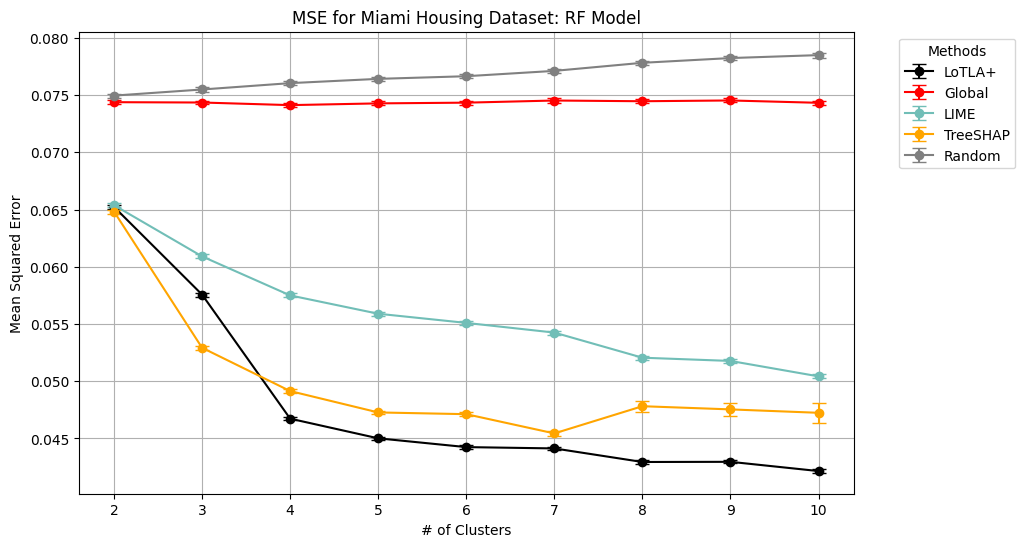

In [8]:
# plot the data
# The x-axis values
x_values = np.array(range(2, mean_df.shape[0]+2), dtype = int)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each column as a separate line with error bars
for col in mean_df.columns:
    if methods_name[col] == 'LoTLA':
        continue
    plt.errorbar(x_values, mean_df[col], yerr=sd_df[col],
                 label=methods_name[col], color=color_map[col],
                 fmt='-o', capsize=5)

# Adding labels and title
plt.xlabel("# of Clusters")
plt.ylabel("Mean Squared Error")
plt.title(f"MSE for Miami Housing Dataset: {treemethod.upper()} Model")
# only put x-axis ticks on integers
plt.xticks(x_values)
# move the legend to the side of the plot
plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
# read in coefs for seed 0
methods = ["elastic_nonnormed_nosquared_norank", 'shap', 'random', 'lime']
coef_dict = {}
for method in methods:
    method_coefs = []
    coefs = np.loadtxt(f"../cluster-results/rf/kmeans/linear/361260/seed0/5clusters_clust{4}_{method}_coefs.csv", delimiter=",")
    coef_dict[method] = coefs
print("Maximum Difference Between LIME and LoTLA Coefficients:", np.max(np.abs(coef_dict['elastic_nonnormed_nosquared_norank'] - coef_dict['lime'])))
print("Maximum Difference Between SHAP and LoTLA Coefficients:", np.max(np.abs(coef_dict['elastic_nonnormed_nosquared_norank'] - coef_dict['shap'])))
print("Maximum Difference Between Random and LoTLA Coefficients:", np.max(np.abs(coef_dict['elastic_nonnormed_nosquared_norank'] - coef_dict['random'])))

In [ ]:
print("Difference Between LIME and LoTLA Coefficients:")
pd.DataFrame(coef_dict['elastic_nonnormed_nosquared_norank'] - coef_dict['lime'])

In [ ]:
print("Difference Between SHAP and LoTLA Coefficients:")
pd.DataFrame(coef_dict['elastic_nonnormed_nosquared_norank'] - coef_dict['shap'])

In [ ]:
print("Difference Between Random and LoTLA Coefficients:")
pd.DataFrame(coef_dict['elastic_nonnormed_nosquared_norank'] - coef_dict['random'])

In [ ]:
pd.DataFrame(coef_dict['elastic_nonnormed_nosquared_norank'])

In [ ]:
coef_dict['elastic_nonnormed_nosquared_norank'].std(axis=0)[:2]

In [ ]:
coef_dict['shap'].std(axis=0)[:2]

In [ ]:
pd.DataFrame(coef_dict['shap'])